<a href="https://colab.research.google.com/github/glebmikha/ab-testing-course/blob/main/07_continious_ab_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Мой Telegram-канал: https://t.me/mikhaylovgleb

## А/Б тест: длительность сессии

In [ ]:
import pandas as pd
import numpy as np

Представим, что мы сотрудники X и работаем над улучшением рекомендательной системы: какие твиты показывать пользователю, чтобы ему было максимально интересно? Для того чтобы понять, что пользователю "стало интереснее", мы решили использовать длительность сессии, т.е. сколько времени пользователь проводит в приложении или на сайте, когда туда заходит.

# Анализ исходных данных

Данные по длине пользовательских сессий (в секундах) за последнее время выглядят следующим образом. (Я сгенерирую эти данные с помощью логнормального распределения).

In [ ]:
np.random.seed(0)
df = pd.DataFrame({'session_len':np.random.lognormal(6,0.8,size=20000)})

In [ ]:
df.head()

,session_len
0,1654.479732
1,555.642869
2,882.704409
3,2422.885730
4,1797.310019


<Axes: >

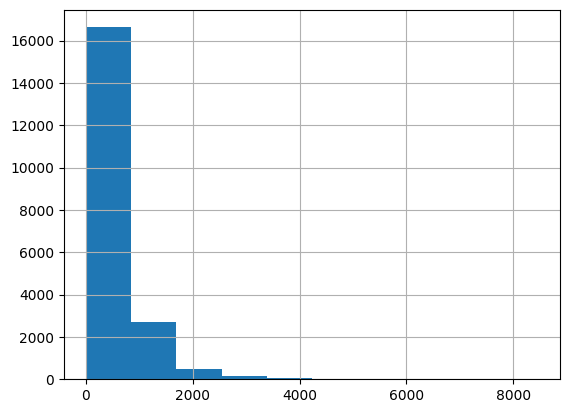

In [ ]:
df['session_len'].hist()

In [ ]:
df['session_len'].mean()

551.7592711731097

В среднем пользовательская сессия длится 552 секунды или около 9 минут. Видим, что в основном сессии короткие, но бывают и достаточно длинные.

# Гипотезы

Мы собираемся протестировать изменение в рекомендательном алгоритме, мы придумали кое-какое нововведение, которое по нашему мнению должно сделать ленту более интересной, и, следовательно, время сессии увеличится.

Мы уже знаем, что подобного рода гипотезы проверяются с помощью А/Б теста с контрольной и тестовой группой. Мы не можем просто включить новые рекомендация для всех пользователей, потому что мы можем не понять за счет чего произошло изменение в длине сессии: за счет новых рекомендаций или по каким-то другим неизвестным причинам.

Значит, у нас будет две группы:

- Контрольная (А): в этой группе пользователи будут видеть старые рекомендации

- Тестовая (Б): в этой группе пользователи будет видеть новые рекомендации.

Сразу сформулируем нулевую и альтернативную гипотезы. В случае А/Б теста они стандартные:

- H0: средняя длина пользовательской сессии в группе А и в группе Б равны

- H1: средняя длина пользовательской сессии в группе А и в группе Б не равны

Альтернативная гипотеза в случае А/Б теста в большинстве случаев двухсторонняя. В этом случае нас так же интересуют отклонение средней длительности как вниз, так и вверх, и поэтому альтернатива выбрана двухсторонняя.

# Требования к тесту

Дальше нужно решить какие минимальный эффект, мощность и альфу (значимость) мы хотим получить для этого теста.

Предположим, что нам интересно отслеживать изменение длины пользовательской сессии минимум на 1 минуту или на 60 секунд. Данных у нас в X много, поэтому мы вполне можем позволить себе мощность 90% и альфу 1%.

И так, мы хотим чтобы тест:

- мог обнаружить изменение пользовательской сессии минимум на 60 секунд

- имел мощность в 90%, т.е. обнаруживал наличие отклонения в 90% случаев, когда оно действительно есть

- имел альфу 1%, т.е. обнаруживал наличие отклонения только  в 1% случаев, когда отклонения на самом деле нет. Ложное срабатывание только в 1% случаев.

# Проверка можно ли использовать t-test

Какой метод расчета p-value будем использовать? Длина пользовательской сессии – это непрерывная переменная, поэтому здесь мы будем использовать t test.

## Нормальность выборочного среднего

Но у ти-теста есть требование: выборочное среднее должно быть распределено нормально. Это нужно проверить.

У нас есть выборка в 20000 сессий. С помощью бутстрепа посмотрим, как будет распределено выборочное среднее при таком размере выборке. Будем брать подвыборки с возвращением, считать среднее и сохранять в список.

In [ ]:
n = 1000
result = []
for i in range(n):
    mean = df['session_len'].sample(frac=1,replace=True,random_state=i).mean()
    result.append(mean)

Сделаем из списка датафрейм чтобы было удобно работать.

In [ ]:
t = pd.DataFrame({'sample_mean':result})

Посмотрим на гистограмму.

<Axes: >

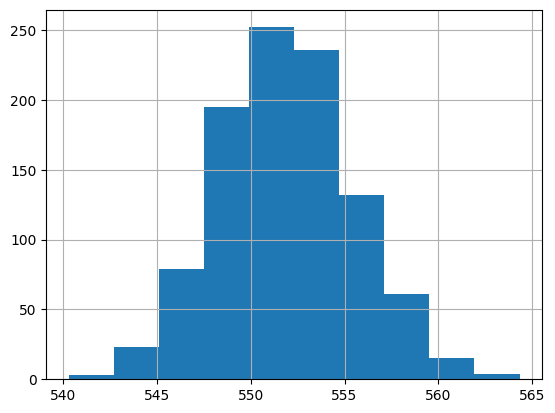

In [ ]:
t['sample_mean'].hist()

Кажется, что распределение вполне нормальное. Подтвердим ку-ку графиком.

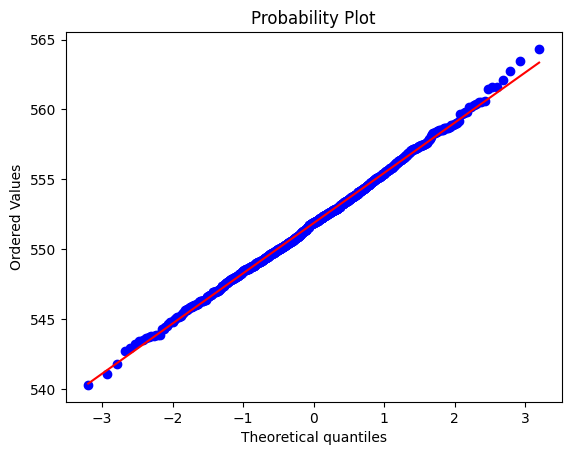

In [ ]:
import pylab
import scipy.stats as stats

stats.probplot(t['sample_mean'], dist="norm", plot=pylab)
pylab.show()

Да, распределение вполне можно считать нормальным. T-test использовать можно!

## Проверка соответствия реального FPR желаемому

Чтобы быть совсем уверенными в том, что в этом случае можно использовать t-test, посмотрим, соответствует ли альфа реальной вероятности ошибки первого рода. Для этого нам потребуется сам t test (для двух выборок). Его можно взять в scipy.stats

In [ ]:
from scipy.stats import ttest_ind

Он принимает на вход две выборки, я сгенерирую их как подвыборки из нашей основной выборки.

In [ ]:
a = df['session_len'].sample(frac=1,replace=True,random_state=0)

In [ ]:
b = df['session_len'].sample(frac=1,replace=True,random_state=1)

Сам тест работает следующим образом.

In [ ]:
ttest_ind(a,b,equal_var=False,alternative='two-sided')

TtestResult(statistic=0.9229679359331525, pvalue=0.3560294853313042, df=39977.35885998961)

Он принимает на вход:

- две выборки, для которых мы хотим рассчитать p-value

- параметр equal_var равный False. Это означает, что у нас нет оснований считать, что выборки имеют одинаковую дисперсию. При проведении ти-теста всегда следует ставить это параметр на False, т.к. мы на самом деле никогда не можем быть уверены, что выборки имеют одинаковую дисперсию. Кстати, ти-тест с параметром equal_var=False называют ти-тестом Уэлча (Welch).

- тип альтернативы

Теперь проверим, соответствует ли альфа реальной вероятности ошибки первого рода (fpr). Для этого будем генерировать подвыборки из исходной выборки и считать для них p-value.

In [ ]:
n = 1000
result = []
for i in range(n):
    a = df['session_len'].sample(frac=1,replace=True,random_state=i)
    b = df['session_len'].sample(frac=1,replace=True,random_state=n-i)
    pvalue = ttest_ind(a,b,equal_var=False,alternative='two-sided')[1]
    result.append((a.mean(),b.mean(),abs(a.mean() - b.mean()),pvalue))

In [ ]:
t = pd.DataFrame(result,columns=['a_mean','b_mean','diff_abs','p-value'])

In [ ]:
t

,a_mean,b_mean,diff_abs,p-value
0,553.825178,553.846938,0.021760,0.996650
1,549.060402,543.704810,5.355592,0.292565
2,551.383030,550.608622,0.774408,0.881639
3,552.195045,552.819455,0.624410,0.904394
4,553.769217,549.872458,3.896758,0.450375
...,...,...,...,...
995,554.599701,552.788058,1.811644,0.731943
996,549.872458,553.769217,3.896758,0.450375
997,552.819455,552.195045,0.624410,0.904394
998,550.608622,551.383030,0.774408,0.881639


Каждая строчка в этой таблице:

- средняя длина сессии в контрольной группе

- средняя длина сессии в тестовой группе

- разница между двумя средними по модулю

- p-value: вероятность получить минимум такое различие между средними при условии, что среднее в контрольной и тестовой группе равны

Отвергнем нулевую гипотезу с альфой равной 1%, и посмотрим какую долю ошибок первого рода мы тут допустим: ведь мы знаем, что нулевая гипотеза здесь заведома верна для всех строк.

In [ ]:
(t['p-value'] < 0.01).mean()

0.004

Вполне ок. И также с помощью ку-ку графика сравним распределение p-value c равномерным распределением.

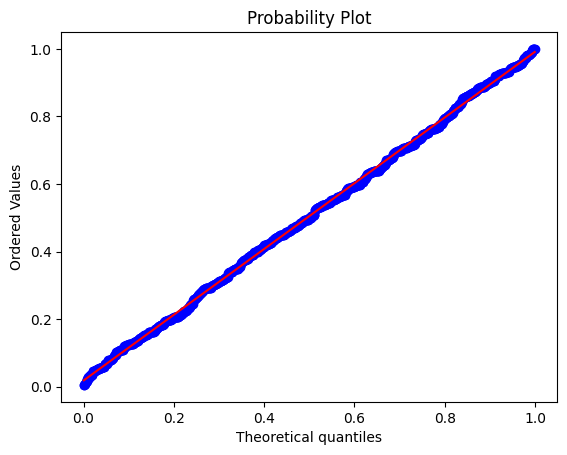

In [ ]:
import pylab
import scipy.stats as stats

stats.probplot(t['p-value'], dist="uniform", plot=pylab)
pylab.show()

Распределение p-value равномерное, а значит ошибка первого рода всегда будет соответствовать альфе. T-test проверен со всех сторон.

# Расчет размера выборок

Теперь уже можно взять все параметры и рассчитать необходимые размеры выборок. Это делается с помощью statsmodels.

In [ ]:
! pip install statsmodels

In [ ]:
import statsmodels.stats.api as sms

Здесь нужно рассчитать размер эффекта по формуле: минимальный эффект (мы решили что это будет минимум 60 секунд) делить на стандартное отклонение. Сразу и посчитаем.

In [ ]:
es = 60 / df['session_len'].std()

In [ ]:
es

0.11525758357186915

Не важно, что это такое, важно что это необходимо для использования этой функции. Теперь можем уже рассчитать необходимые размеры выборок.

In [ ]:
sms.TTestIndPower().solve_power(es, power=0.90, alpha=0.01, ratio=1, alternative='two-sided')

2241.803908256248

Параметры здесь такие же, как и у z-test для пропорций, ничего необычного. И также можно задавать ratio: отношение размера тестовой группы к размеру контрольной группы.

Получилось, что нам нужно всего 2242 наблюдения в каждой группе. А будет ли ти тест давать нормальные результаты при такой маленькой выборке? Посмотрим на распределение p-value для верной нулевой гипотезы при таких выборках.

In [ ]:
n = 1000
result = []
for i in range(n):
    a = df['session_len'].sample(2242,replace=True,random_state=i)
    b = df['session_len'].sample(2242,replace=True,random_state=n-i)
    pvalue = ttest_ind(a,b,equal_var=False,alternative='two-sided')[1]
    result.append((a.mean(),b.mean(),abs(a.mean() - b.mean()),pvalue))

In [ ]:
t = pd.DataFrame(result,columns=['a_mean','b_mean','diff_abs','p-value'])

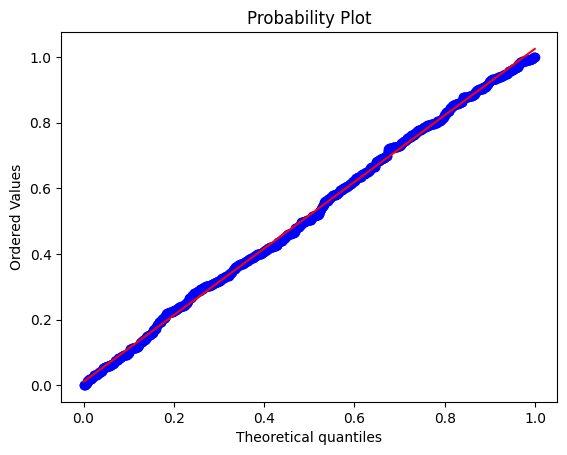

In [ ]:
import pylab
import scipy.stats as stats

stats.probplot(t['p-value'], dist="uniform", plot=pylab)
pylab.show()

Тоже очень даже равномерное. Отлично.

# Проверяем соответствует ли реальный TPR мощности

И теперь интересно проверить, будет ли у теста реально мощность 90% при таком размере выборки? Что нам для этого нужно? Распределение соответствующее альтернативной гипотезе. И если в случае с конверсией распределение всегда было биномиальное и мы легко могли его получить, то в случае с непрерывными переменными все намного сложнее.

Непрерывных распределений существует огромное количество, и мы можем даже не знать тип того распределения, с которым мы имеем дело. И даже если мы попытаемся установить тип распределения, то нет никакой гарантии, что мы сделали это правильно – это непростая задача.

Что самое простое мы можем сделать, чтобы получить распределение со средним, которое больше на 60 секунд? Можно просто прибавить 60 к каждому наблюдению в нашей выборке!

Вот исходное среднее.

In [ ]:
df['session_len'].mean()

551.7592711731097

Вот измененное.

In [ ]:
(df['session_len'] + 60).mean()

611.7592711731098

Это очень грубый трюк, т.к. в реальности среднее может повыситься например за счет того, что у нас появится больше длинных сессий, а короткие ни как не изменятся. Но это хоть что-то.

Посчитаем мощность для распределения альтернативной гипотезы полученного таким образом.

In [ ]:
n = 1000
result = []
for i in range(n):
    a = df['session_len'].sample(2242,replace=True,random_state=i)
    b = (df['session_len'] + 60).sample(2242,replace=True,random_state=n-i)
    pvalue = ttest_ind(a,b,equal_var=False,alternative='two-sided')[1]
    result.append((a.mean(),b.mean(),abs(a.mean() - b.mean()),pvalue))

In [ ]:
t = pd.DataFrame(result,columns=['a_mean','b_mean','diff_abs','p-value'])

Отвергнем нулевую гипотезу при альфа равной 1% и посчитаем долю отвергнутых нулевых гипотез.

In [ ]:
(t['p-value'] < 0.01).mean()

0.915

Мощность соответствует нашим расчетам! Круто.

То, что мы не можем нормально симулировать распределение альтернативной гипотезы создает нам только одну проблему: мы не можем подбирать размеры выборки с помощью бутстрапа, т.к. нам неоткуда генерить выборки соответствующие нулевой гипотезе. Но хорошо, что у нас есть ти тест, которому вообще не важно какое распределение имеет переменная, которую мы исследуем: лишь бы выборочное среднее было распределено нормально. И мы всегда можем это проверить и понять пригоден ли ти-тест в каждом конкретном случае.

# Увеличиваем значимость

Кстати, в этом случае, мы можем себе позволить альфу в 0.1%. Давай попробуем посмотреть размеры выборки при такой альфе.

In [ ]:
es = 60 / df['session_len'].std()


In [ ]:
sms.TTestIndPower().solve_power(es, power=0.90, alpha=0.001, ratio=1, alternative='two-sided')

3149.8636773334183

Размер выборки вырос не сильно. Можем еще уменьшить минимальный эффект и повысить мощность.

In [ ]:
es = 30 / df['session_len'].std()
sms.TTestIndPower().solve_power(es, power=0.95, alpha=0.001, ratio=1, alternative='two-sided')


14671.428299061146

Чтобы провести тест с минимальным эффектом в 30 секунд, мощностью 95% и вероятностью ошибки первого рода в 0.1% потребуется 14671 наблюдений как в контрольной, так и в тестовой группе. Поскольку мы работаем в X, то вполне можем позволить себе выборки таких размеров.

Вообще в больших интернет компаниях обычно используют очень маленькие альфы, даже меньше чем 0.1%. Во-первых, они могут себе это позволить, т.к. пользователей много, а во вторых это позволяет нивелировать эффект множественной проверки гипотез.

О множественной проверке надо говорить отдельно, но если вкратце, то когда одновременно проводится много тестов, то повышается вероятность чисто случайно "словить" значимые результаты.

# Оценка результатов

Закончим пример с X. Я провел А/Б тест с высчитанными нами размерами выборок и получил следующие результаты. (Снова воспользуюсь логнормальным распределением)

Сгенерим контрольную группу.

In [ ]:
np.random.seed(0)
a = np.random.lognormal(6.01,0.8,size=14700)

Сгенерим тестовую группу.

In [ ]:
np.random.seed(0)
b = np.random.lognormal(6.09,0.76,size=14690)

Среднее в контрольной группе получилось

In [ ]:
a.mean()

554.2418516752615

Среднее в тестовой получилось

In [ ]:
b.mean()

582.4048873495988

Теперь посчитаем p-value, т.е. вероятность получить минимум такую разницу между группами, при условии, что средние на самом деле равны.

In [ ]:
ttest_ind(a,b,equal_var=False,alternative='two-sided')

TtestResult(statistic=-4.655821612779527, pvalue=3.2410094260042674e-06, df=29379.0510219584)

Тут p-value вывелось в виде научной нотации: e-06 означает 10 в степени -6. Т.е. здесь p-value получилось равным 3 * 10 ** -6 – это меньше чем выбранная нами альфа в 0.1% или 0.001. Поэтому я отвергаю нулевую гипотезу о том, что группы имеют равное среднее в пользу альтернативной гипотезы: среднее в контрольной группе не равно среднему в тестовой группе.

У меня получился значимый тест, средние не равны и по данным я вижу, что тестовая группа имеет более длинную пользовательскую сессию. Значит, я делаю вывод, что изменение в рекомендательной системе оказало положительный эффект и могу раскатывать это изменение для всех пользователей.

Мой Telegram-канал: https://t.me/mikhaylovgleb